# Notebook for the making of Figure 5 - Fine Tuning

In [1]:
import numpy as np
import pylab as plt
from numpy.fft import fftshift, ifftshift
import tensorflow as tf 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
from predict_phase_2D_utilities import *

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from functions import*
from interpolation_functions import*
from line_cross_standard_utilities import *
from line_cross_tensorflow_prediction_utilities import *

plt.rcParams['image.cmap'] = 'plasma'

2.2.0
Num GPUs Available:  1


2023-12-15 18:26:18.558174: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-12-15 18:26:18.678887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.50GiB deviceMemoryBandwidth: 836.37GiB/s
2023-12-15 18:26:18.685931: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-12-15 18:26:18.700743: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-12-15 18:26:18.707384: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-12-15 18:26:18.714444: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

# Load a diffraction pattern

In [2]:
path = 'path_for_image3'
data_full = np.load(path)
data = data_full['I']
data = np.swapaxes(data,1,2)


# Add mask and preprocess

In [3]:
mask = add_vertical_gap3D(data, gap_size = 6, gap_position = 64, min_distance_from_center = 0)
data_masked_linear = data*(1.-mask)
data_masked, maxi_rescale1, maxi_rescale2 = data_preprocessing(data_masked_linear)
gap_params = find_gap_parameters(mask, verbose=True)

gap_shape : line
axis_perpendicular : 1
gap_size : 6
mask_position : 63


# Load the corresponding model

In [4]:
from tensorflow.keras import losses
keras.losses.custom_loss = MyLoss_noisy

model_path = '/data/projects/id01ml/SavedModels/3D_inpainting_portions32_{}px_cross/'.format(gap_params['gap_size'])
print('model path :', model_path)
if os.path.exists(model_path):
    print('This gap size model exists')
    import tensorflow as tf 
    print(tf.__version__)
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    model = tf.keras.models.load_model(model_path, custom_objects=None, compile=False)
    new_model = tf.keras.models.load_model(model_path,custom_objects = {'MyLoss_noisy' :MyLoss_noisy})
    print('Models loading done.')
else:
    print('Error, this gap size model doesn\'t exits yet')

model path : /data/projects/id01ml/SavedModels/3D_inpainting_portions32_6px_cross/
This gap size model exists
2.2.0
Num GPUs Available:  1


2023-12-15 18:26:23.784067: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3800000000 Hz
2023-12-15 18:26:23.785195: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2f717600 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-15 18:26:23.785212: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-15 18:26:23.927124: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2f6863c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-15 18:26:23.927167: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-12-15 18:26:23.927572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 d

Models loading done.


# Create a dataset generator from the target image

In [5]:
dataset = create_target_dataset(data, mask, nb_images = int(32*200))
data_gen = create_datagenerator_ft(dataset, gap_size = gap_params['gap_size'])

In [6]:
acc = 0
tot_loss = 0
for i in range(32):
    X,y = data_gen.__getitem__(i)
    y_pred = model(X)
    acc += accuracy(y[:,...,0], y_pred[:,...,0], y[:,...,1])
    
    loss = np.mean(MyLoss_noisy(y,y_pred))
    tot_loss+=loss
print('The average pretrained model accuracy is: ', acc/32)
print('The average pretrained model loss is: ', tot_loss/32)


2023-12-13 14:33:16.629722: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-12-13 14:33:22.860794: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


The average pretrained model accuracy is:  68.61349083483219
The average pretrained model loss is:  2.224277563393116


In [7]:
loss = MyLoss_noisy
optimizer=tf.keras.optimizers.Adam(learning_rate=5e-8)

loss_train = []
loss_val = []

new_model.compile(optimizer=keras.optimizers.Adam(),
              loss=MyLoss_noisy)

In [8]:
history = new_model.fit(data_gen, epochs=2)

Epoch 1/2
200/200 [==============================] - 29s 146ms/step - loss: 1.7941
Epoch 2/2
200/200 [==============================] - 29s 146ms/step - loss: 1.4354


In [9]:
skip_pixels = 0
prediction_ft = gap_prediction(data_masked, mask, gap_params, new_model,
                   skip_pixels=skip_pixels)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 39 39 

In [10]:

skip_pixels = 0
prediction_gen = gap_prediction(data_masked, mask, gap_params, model,
                   skip_pixels=skip_pixels)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 39 39 

In [11]:
prediction_linear_ft = post_processing_prediction(prediction_ft, maxi_rescale1, maxi_rescale2)
prediction_linear_gen = post_processing_prediction(prediction_gen, maxi_rescale1, maxi_rescale2)


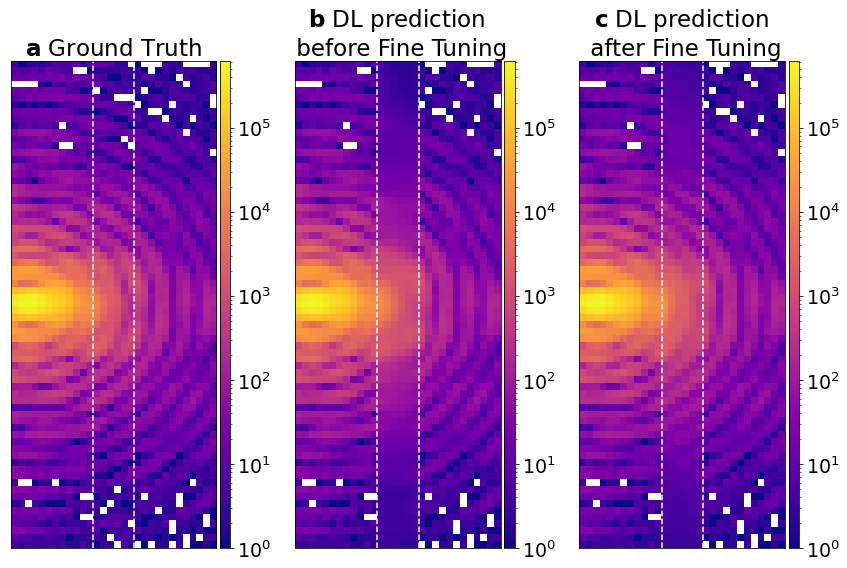

In [16]:
from matplotlib.colors import LogNorm

delta=15

nrow = 1
ncol = 3
fig,ax = plt.subplots(nrow,ncol, figsize=(4*ncol,8*nrow))

img = []
img.append(ax[0].imshow(data[:,64-delta:64+delta,81], norm = LogNorm(vmin = None, vmax = None)))

ax[0].axvline(x = 11.5,color = 'w', linestyle = 'dashed')
ax[0].axvline(x = 17.5,color = 'w', linestyle = 'dashed')
ax[0].set_title('$\mathbf{a}$ Ground Truth', fontsize = 23)
img.append(ax[1].imshow(prediction_linear_gen[:,64-delta:64+delta,81],norm = LogNorm(vmin = None, vmax = None)))

ax[1].axvline(x = 11.5,color = 'w', linestyle = 'dashed')
ax[1].axvline(x = 17.5,color = 'w', linestyle = 'dashed')

ax[1].set_title('$\mathbf{b}$ DL prediction \n before Fine Tuning', fontsize = 23)

img.append(ax[2].imshow(prediction_linear_ft[:,64-delta:64+delta,81], norm = LogNorm(vmin = None, vmax = None)))
ax[2].axvline(x = 11.5,color = 'w', linestyle = 'dashed')
ax[2].axvline(x = 17.5,color = 'w', linestyle = 'dashed')
ax[2].set_title('$\mathbf{c}$ DL prediction \n after Fine Tuning', fontsize = 23)


ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])

ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])

for ii, im in enumerate(img):
    divider = make_axes_locatable(ax[ii])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=19)
        
fig.tight_layout()
